In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import tomotopy as tp
### WORDCLOUD
import spacy
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

sns.set_style("whitegrid")

### SENTIMENT VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from flair.models import TextClassifier
from flair.data import Sentence

#classifier = TextClassifier.load('en-sentiment')
# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

# You may need to download the vader_lexicon if you haven't already, you can do so using this line of code:
# nltk.download('vader_lexicon')


def combine(x):
        out = ""
        cols = ['title', 'pros', 'cons', "text"]
        for col in cols:
                if type(x[col]) == str:
                        out += x[col] + ". "
        return out


companies = ['uber', 'uber-drivers', 'ubereats', 'lyft', 'instacart', 'grubhub', 'doordash', 'postmates']
nlp = spacy.load('en_core_web_sm')

def text2lemma(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc 
                         if not token.is_stop and token.text not in companies]

    return " ".join(lemmas)

def number_of_months(date):
    return (date.year - 2018) * 12 + date.month - 1

In [3]:
paths = ["indeed_reviews_ma.csv", "indeed_reviews_ca.csv", "indeed_reviews_ny.csv", "indeed_reviews_tx.csv"]
df = pd.concat([pd.read_csv(path, index_col="id") for path in paths])
df["datetime"] = pd.to_datetime(df["datetime"])
#df = df[(df["is_driver"]) & (df["reviewer_employee_type"] == "Current Employee")]
df = df[(df["reviewer_employee_type"] == "Current Employee")]
df["before"] = df["datetime"].apply(lambda x: (x >= pd.to_datetime("2020-06-01") and (x < pd.to_datetime("2021-01-01"))))
df["after"] = df["datetime"].apply(lambda x: (x >= pd.to_datetime("2021-06-01") and (x < pd.to_datetime("2022-01-01"))))


cols = ['job_work_and_life_balance_rating', 'compensation_and_benefits_rating', 
        'job_security_and_advancement_rating', 'management_rating', 'job_culture_rating']
df["mean_rate"] = df.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)
df["combined_text"] = df.apply(lambda x: combine(x), axis=1)


df["sentiment_vader"] = df.apply(lambda x: sid.polarity_scores(combine(x))["compound"], axis=1)
df.to_csv("indeed_reviews_super_cleaned_all.csv")

In [4]:
ndf = pd.read_csv("indeed_reviews_super_cleaned_all_nrc.csv", index_col="id")
ndf = ndf[['NRC Disposition', 'NRC Anger', 'NRC Anticipation', 'NRC Disgust',
       'NRC Fear', 'NRC Joy', 'NRC Sadness', 'NRC Surprise', 'NRC Trust']]
df = df.join(ndf, how="left")

In [5]:
df['processed_text'] = df['combined_text'].apply(text2lemma)

In [6]:
words_before = " ".join(df[df["before"] & df["is_driver"]]["processed_text"].values)
words_after = " ".join(df[df["after"] & df["is_driver"]]["processed_text"].values)

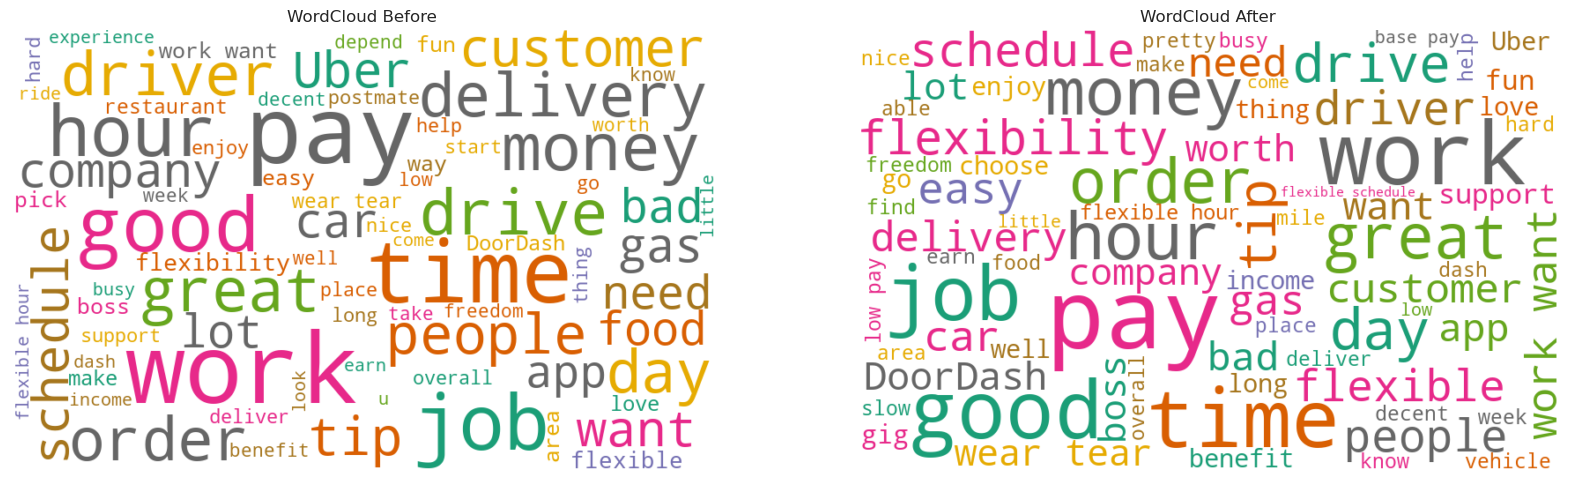

In [7]:
wordcloud_before = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white", 
                      colormap="Dark2", max_words=75).generate(words_before)

wordcloud_after = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white", 
                      colormap="Dark2", max_words=75).generate(words_after)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Display wordcloud 1
ax1.imshow(wordcloud_before, interpolation="bilinear")
ax1.axis('off')
ax1.set_title('WordCloud Before')

# Display wordcloud 2
ax2.imshow(wordcloud_after, interpolation="bilinear")
ax2.axis('off')
ax2.set_title('WordCloud After')

plt.show()

In [143]:
tdf = df[(df["is_driver"]) & (df["year"] > 2017 ) & (df["year"] < 2023 )]
corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())

for i, row in tqdm(tdf.iterrows()):
    text = row["processed_text"]
    corpus.add_doc(raw=text)

model = tp.PAModel.load("topic_modeling.model")
infered, ll = model.infer(corpus)
infered, ll = model.infer(corpus)
topic_data = np.zeros((len(infered),model.k2) )
for i, doc in enumerate(infered):
    temp = doc.get_sub_topics()
    for item in temp:
        topic_data[i, item[0]] = item[1]
tdf["topic"] = np.argmax(topic_data, axis=1)

0it [00:00, ?it/s]

5097it [00:00, 6719.78it/s]
/tmp/ipykernel_322/461007726.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["topic"] = np.argmax(topic_data, axis=1)


/tmp/ipykernel_322/1290589412.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')
/tmp/ipykernel_322/1290589412.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')
/tmp/ipykernel_322/1290589412.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')
/tmp/ipykernel_322/1290589412.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')
/tmp/ipykernel_322/1290589412.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')


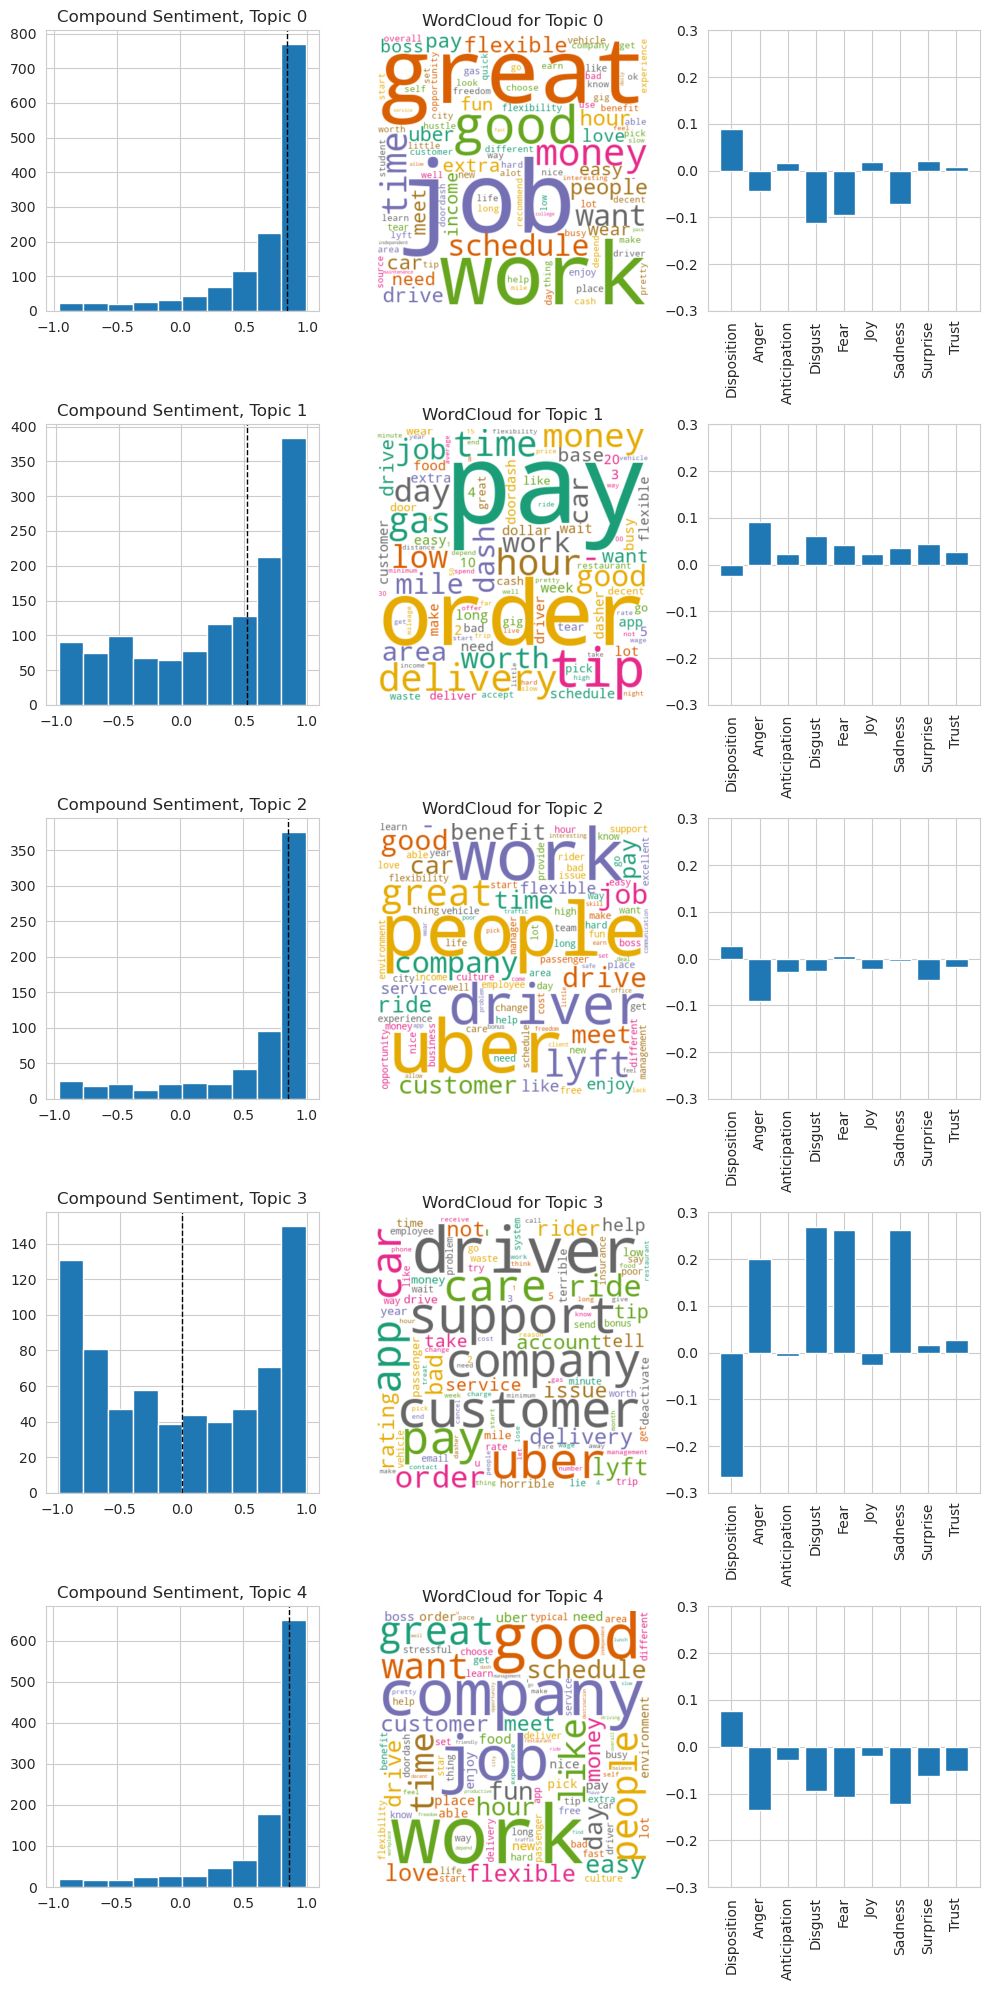

In [144]:
fig, ax = plt.subplots(model.k2,3, figsize=(10, 20))

gl_scores = tdf[['NRC Disposition', 'NRC Anger', 'NRC Anticipation', 'NRC Disgust',
       'NRC Fear', 'NRC Joy', 'NRC Sadness', 'NRC Surprise', 'NRC Trust']].mean().tolist()


for i in range(model.k2):
    
    scores = tdf[(tdf["topic"] == i)]["sentiment_vader"]
    ax[i, 0].hist(scores, bins=10)
    ax[i, 0].set_title("Compound Sentiment, Topic %s" %i)
    ax[i, 0].axvline(scores.median(), color='k', linestyle='dashed', linewidth=1)
    
    wc = WordCloud(height=400, width=400, background_color="white", colormap="Dark2")
    vocab = dict()
    for item in model.get_topic_words(i, top_n=100):
        vocab[item[0]] = item[1]
    ax[i,1].imshow(wc.generate_from_frequencies(vocab), interpolation="bilinear")
    ax[i,1].set_title("WordCloud for Topic %s" %i)
    ax[i,1].axis("off")
    
    scores = tdf[(tdf["topic"] == i)][['NRC Disposition', 'NRC Anger', 'NRC Anticipation', 'NRC Disgust',
       'NRC Fear', 'NRC Joy', 'NRC Sadness', 'NRC Surprise', 'NRC Trust']].mean().tolist()
    scores = [scores[i] - gl_scores[i] for i in range(len(scores))]

    labels = ["Disposition", "Anger", "Anticipation", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Trust"]
    ax[i,2].bar(labels, scores)
    ax[i,2].set_xticklabels(labels, rotation=90, horizontalalignment='center')
    ax[i,2].set_ylim([-0.3, 0.3])

plt.tight_layout()

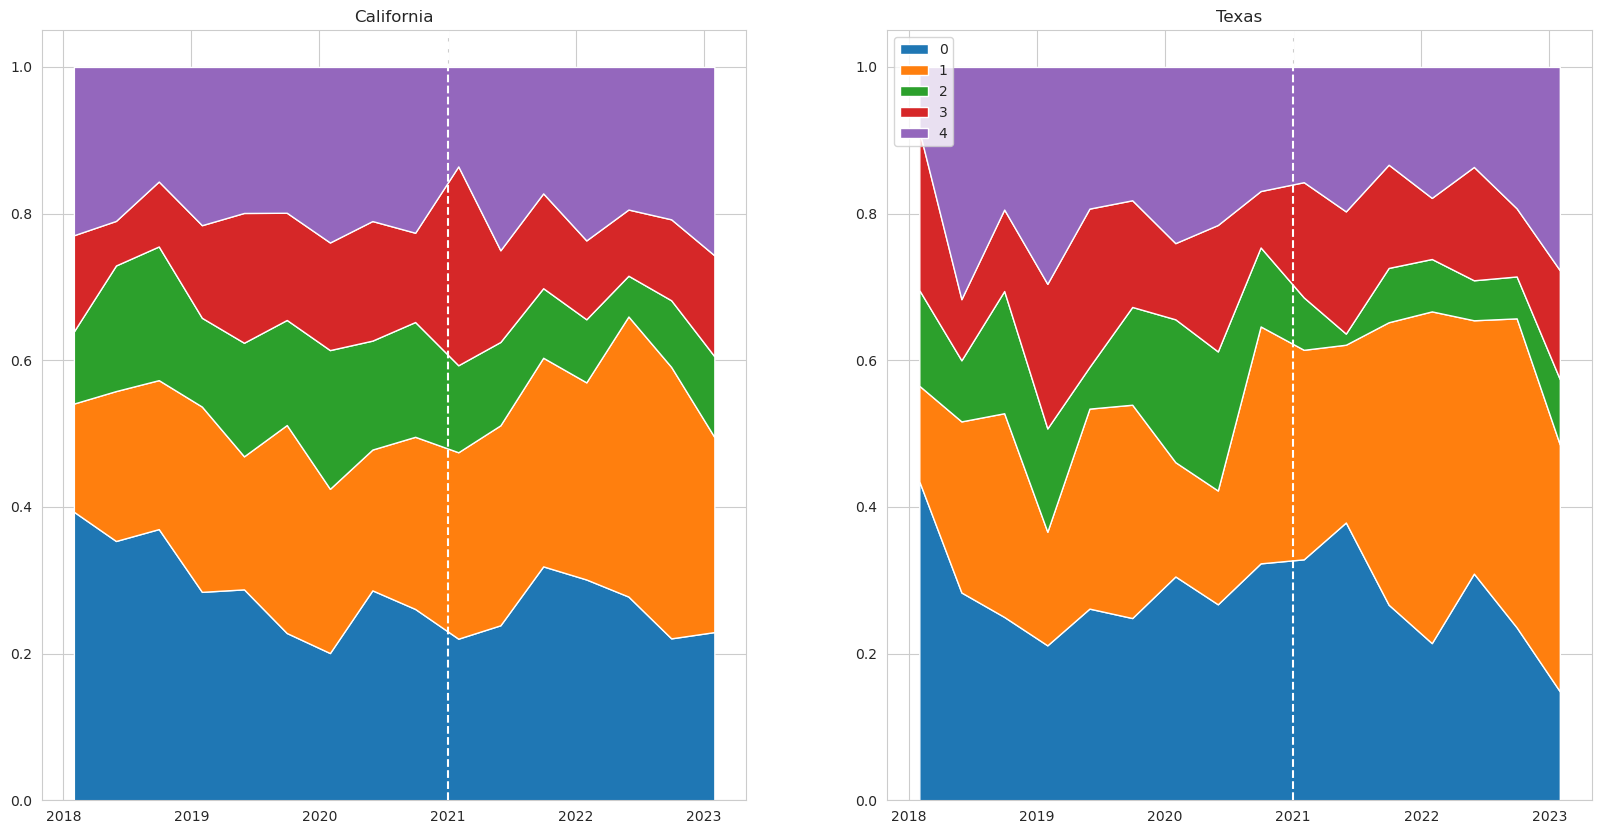

In [150]:
grouped = tdf[tdf["state"] == "ca"].groupby(pd.Grouper(key='datetime', freq='4M'))["topic"].value_counts().unstack()
grouped = grouped.apply(lambda x: x/x.sum(), axis=1)
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].stackplot(grouped.index, grouped.values.T, labels=grouped.columns)
ax[0].axvline(pd.to_datetime("2021-01-01"), color="white", linestyle="--")
ax[0].set_title("California")

grouped = tdf[tdf["state"] == "tx"].groupby(pd.Grouper(key='datetime', freq='4M'))["topic"].value_counts().unstack()
grouped = grouped.apply(lambda x: x/x.sum(), axis=1)
ax[1].stackplot(grouped.index, grouped.values.T, labels=grouped.columns)
ax[1].axvline(pd.to_datetime("2021-01-01"), color="white", linestyle="--")
ax[1].set_title("Texas")

plt.legend(loc='upper left')

In [14]:
df.columns

Index(['title', 'text', 'rating', 'reviewer', 'location', 'cons', 'pros',
       'datetime', 'reviewer_employee_type',
       'job_work_and_life_balance_rating', 'compensation_and_benefits_rating',
       'job_security_and_advancement_rating', 'management_rating',
       'job_culture_rating', 'state', 'company', 'year', 'month', 'is_driver',
       'before', 'after', 'mean_rate', 'combined_text', 'sentiment_vader',
       'NRC Disposition', 'NRC Anger', 'NRC Anticipation', 'NRC Disgust',
       'NRC Fear', 'NRC Joy', 'NRC Sadness', 'NRC Surprise', 'NRC Trust',
       'processed_text'],
      dtype='object')

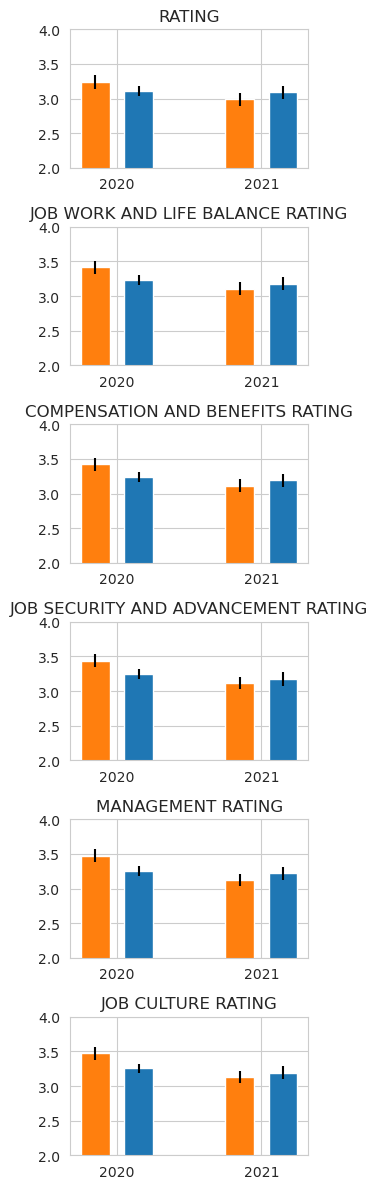

In [141]:
#### CODE
ranking_cols = ["rating", "job_work_and_life_balance_rating", "compensation_and_benefits_rating", "job_security_and_advancement_rating", 
                'management_rating', 'job_culture_rating']
tdf = df[df["state"].isin(["ca", "tx"]) & df["is_driver"]]


fig, ax = plt.subplots(len(ranking_cols), 1, figsize=(3, 12))
for ix, col in enumerate(ranking_cols): 
    years = [2020,2021]
    pos = [i for i in range(len(years))]

    for state in ["ca", "tx"]:
        mu = []
        se = []
        for year in years:
        

            vals = tdf[(tdf["state"] == state) & (tdf["year"] == year) & (tdf[col] > 0)][cols].values
            mu.append(np.mean(vals))
            se.append( np.std(vals, ddof=1) / np.sqrt(float(len(vals))))
        
        if state == "ca": offset = -0.15
        else: offset = 0.15
        ax[ix].bar(x=[p-offset for p in pos], height=mu, yerr=se, width=0.2)
    
    
    ax[ix].set_xticks(pos)
    ax[ix].set_xticklabels(years)
    ax[ix].set_title(col.replace("_", " ").upper())
    ax[ix].set_ylim([2,4])

plt.tight_layout()
plt.show()



In [88]:
len(vals)

264

(1.0, 5.0)

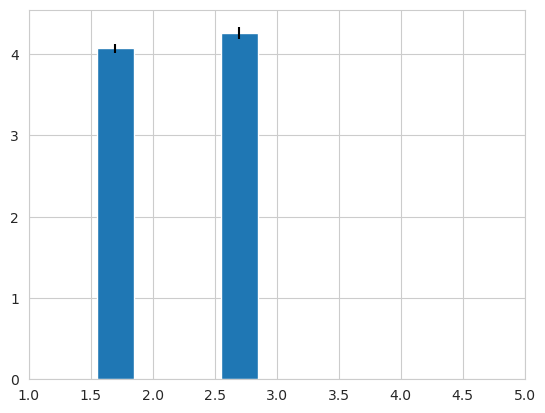

In [92]:
plt.bar(x=[p-0.3 for p in pos], height=mu, yerr=se, width=0.3)
plt.xlim([1,5])

### Archived code

In [3]:
#df.to_csv("indeed_reviews_super_cleaned.csv")

In [192]:
score = []
tag = []
sentiment_pipeline = pipeline("sentiment-analysis")
for text in tqdm(df["combined_text"].tolist()):
    sentence = Sentence(text[:512])
    classifier.predict(sentence)
    score.append(sentence.score)
    tag.append(sentence.tag)
sign = [ -1 if i == "NEGATIVE" else 1 for i in tag ] 
df["sentiment_flair"] = [a * b for a, b in zip(score, sign)]


  0%|          | 0/5097 [00:00<?, ?it/s]

100%|██████████| 5097/5097 [04:23<00:00, 19.36it/s]


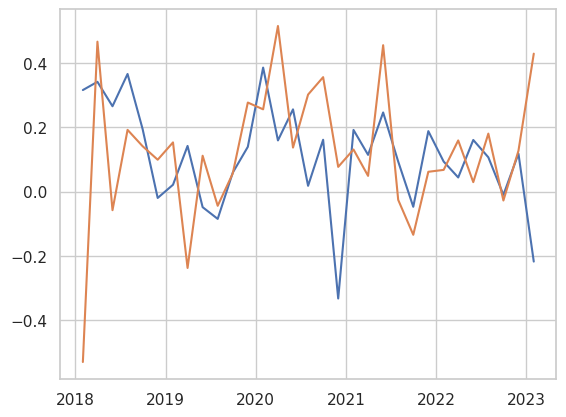

In [208]:
col = "sentiment_flair"
grouped = df[df["state"] == "ca"][["datetime", col]].groupby(pd.Grouper(key='datetime', freq='2M')).mean()  # 'Q' stands for quarter
plt.plot(grouped.index, grouped[col], label="CA")

grouped = df[df["state"] == "tx"][["datetime", col]].groupby(pd.Grouper(key='datetime', freq='2M')).mean()  # 'Q' stands for quarter
plt.plot(grouped.index, grouped[col], label="TX")

In [205]:
_df = df[df["state"] == "ca"]
col = "sentiment_flair"
print( "Mean:", "%.2f" %_df[_df["before"]][col].mean(), "%.2f" % _df[_df["after"]][col].mean())
print( "STD: " , "%.2f" %_df[_df["before"]][col].std(), "%.2f" %_df[_df["after"]][col].std())

Mean: 0.17 0.10
STD:  0.95 0.97


In [135]:
_df = df[df["state"] == "tx"]
print( "Mean:", "%.2f" %_df[_df["before"]]["mean_rate"].mean(), "%.2f" % _df[_df["after"]]["mean_rate"].mean())
print( "STD: " , "%.2f" %_df[_df["before"]]["mean_rate"].std(), "%.2f" %_df[_df["after"]]["mean_rate"].std())

Mean: 3.17 2.90
STD:  1.41 1.27


In [66]:
df_ca = pd.read_csv("indeed_reviews_ca.csv", index_col="id")
df_ca["datetime"] = pd.to_datetime(df_ca["datetime"])
df_ca = df_ca[(df_ca["is_driver"]) & (df_ca["reviewer_employee_type"] == "Current Employee")]

df_tx= pd.read_csv("indeed_reviews_tx.csv", index_col="id")
df_tx["datetime"] = pd.to_datetime(df_tx["datetime"])
df_tx = df_tx[(df_tx["is_driver"]) & (df_tx["reviewer_employee_type"] == "Current Employee")]


df_ny= pd.read_csv("indeed_reviews_ny.csv", index_col="id")
df_ny["datetime"] = pd.to_datetime(df_ny["datetime"])
df_ca = df_ny[(df_ny["is_driver"]) & (df_ny["reviewer_employee_type"] == "Current Employee")]


df = pd.read_csv("indeed_reviews.csv", index_col="id")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df[(df["is_driver"]) & (df["reviewer_employee_type"] == "Current Employee")]

In [75]:
df_ca = df[df["state"] == "ca"]
df_ca = df_ca[(df_ca["datetime"] > "20-04-01") & (df_ca["datetime"] < "20-10-01")]

In [67]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# You may need to download the vader_lexicon if you haven't already, you can do so using this line of code:
# nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

df_ca["sentiment"] = df_ca.apply(lambda x: sid.polarity_scores(x["text"])["compound"], axis=1)
df["sentiment"] = df.apply(lambda x: sid.polarity_scores(x["text"] )["compound"], axis=1)

/tmp/ipykernel_16145/3209336091.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca["sentiment"] = df_ca.apply(lambda x: sid.polarity_scores(x["text"])["compound"], axis=1)


In [68]:
cols = ['job_work_and_life_balance_rating', 'compensation_and_benefits_rating', 'job_security_and_advancement_rating', 'management_rating', 'job_culture_rating']
df_ca["mean_score"] = df_ca.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)
df_tx["mean_score"] = df_tx.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)
df_ny["mean_score"] = df_ny.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)
df["mean_score"] = df.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)

/tmp/ipykernel_16145/3882543555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca["mean_score"] = df_ca.apply(lambda x: np.mean([x[col] for col in cols]), axis=1)


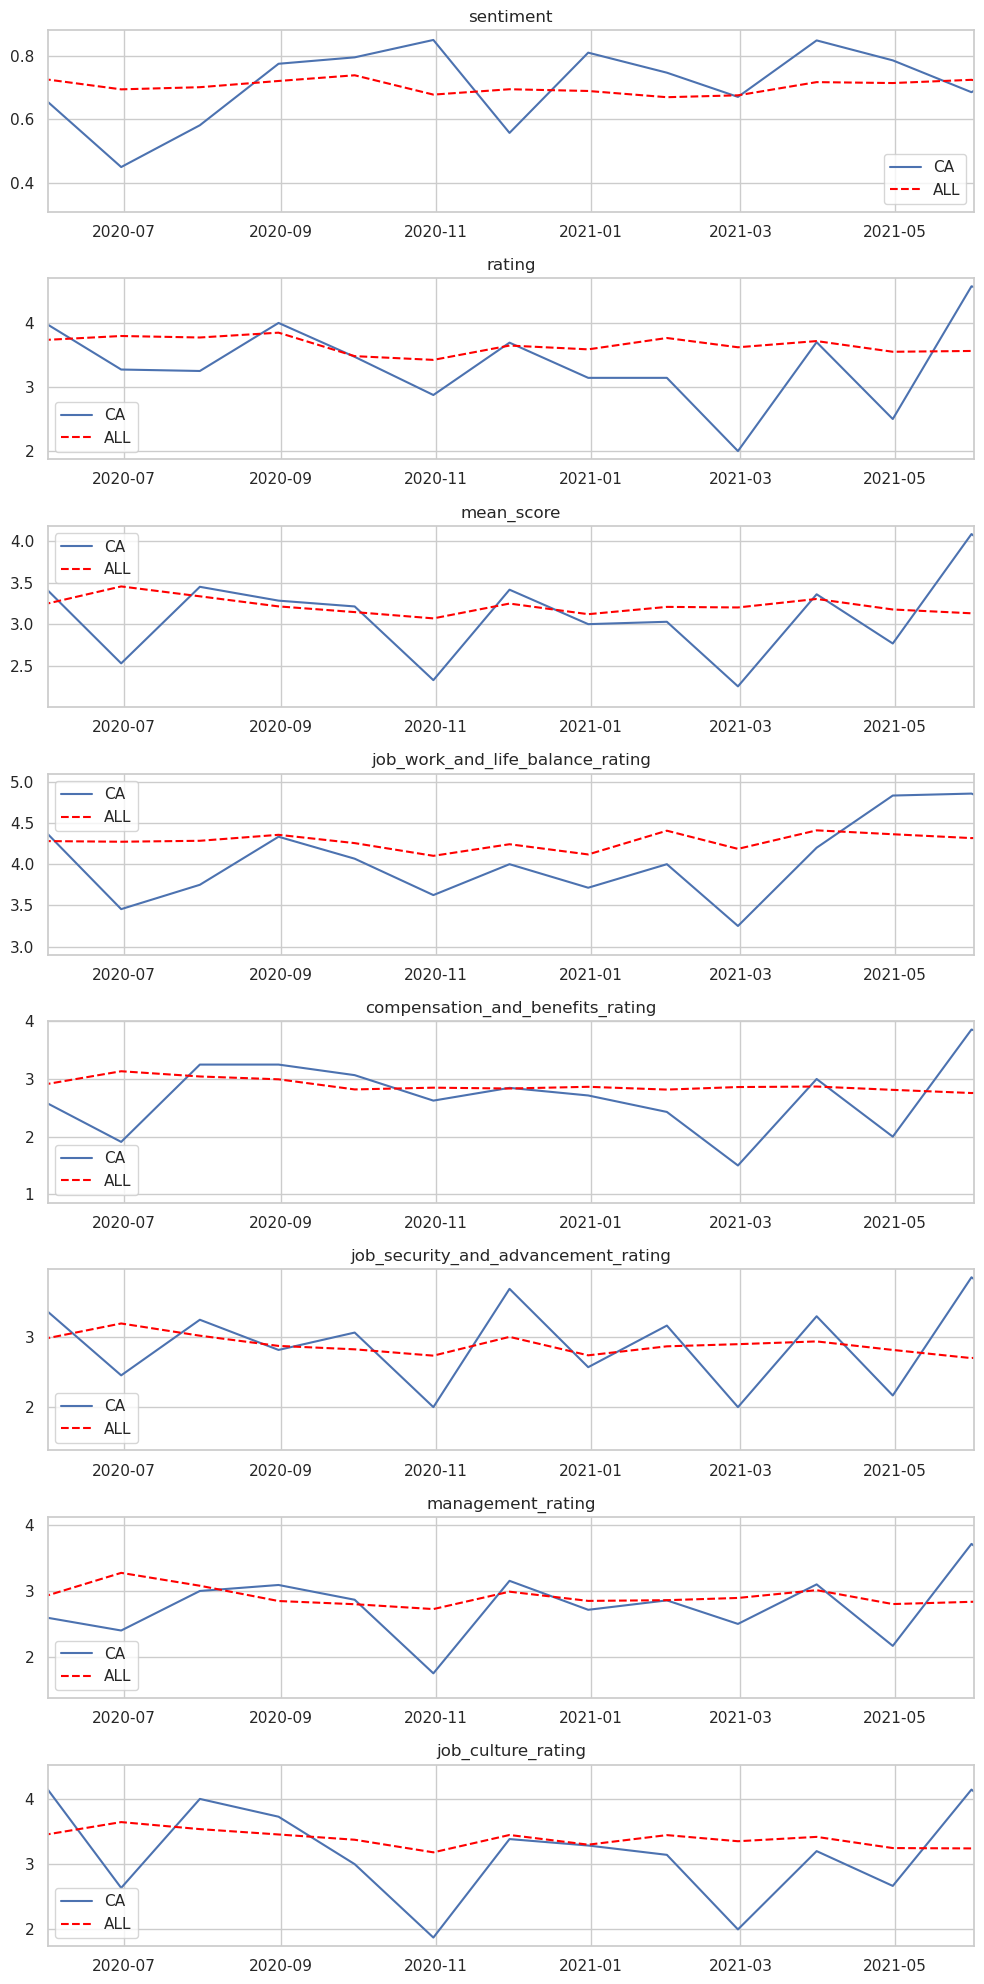

In [69]:
fig, ax = plt.subplots(8, 1, figsize=(10, 20))
cols = [ "sentiment", "rating", "mean_score", 'job_work_and_life_balance_rating', 'compensation_and_benefits_rating', 'job_security_and_advancement_rating', 'management_rating', 'job_culture_rating']
col = "job_security_and_advancement_rating"
for i, col in enumerate(cols):
    ax[i].set_title(col)
    tdf = df_ca[(df_ca[col] > 0)]
    grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='1M')).mean()  # 'Q' stands for quarter
    ax[i].plot(grouped.index, grouped[col], label="CA")
    
    #tdf = df_tx[(df_tx[col] > 0)]
    #grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
    #ax[i].plot(grouped.index, grouped[col], color="red", label="TX", linestyle="--")
    
    tdf = df[(df[col] > 0)]
    grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='1M')).mean()  # 'Q' stands for quarter
    ax[i].plot(grouped.index, grouped[col], color="red", label="ALL", linestyle="--")

    #tdf = df_ny[(df_ny[col] > 0)]
    #grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
    #ax[i].plot(grouped.index, grouped[col], color="green", label="NY", linestyle="--")
    ax[i].legend()
    ax[i].set_xlim([pd.Timestamp('2020-06-01'), pd.Timestamp('2021-06-01')])
plt.tight_layout()

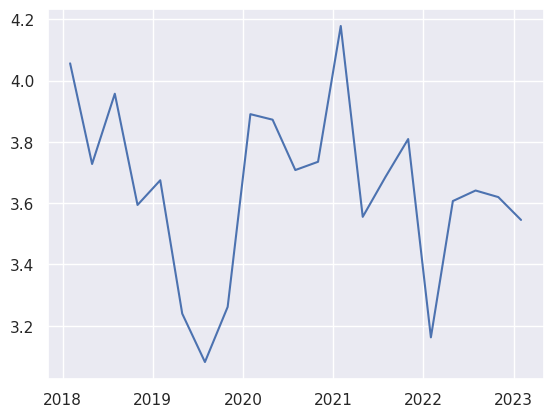

In [64]:
tdf = df[(df[col] > 0) & (df["company"] == company)]
grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
plt.plot(grouped.index, grouped[col])

/tmp/ipykernel_14711/4036901385.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = company_data.groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
/tmp/ipykernel_14711/4036901385.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = company_data.groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
/tmp/ipykernel_14711/4036901385.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

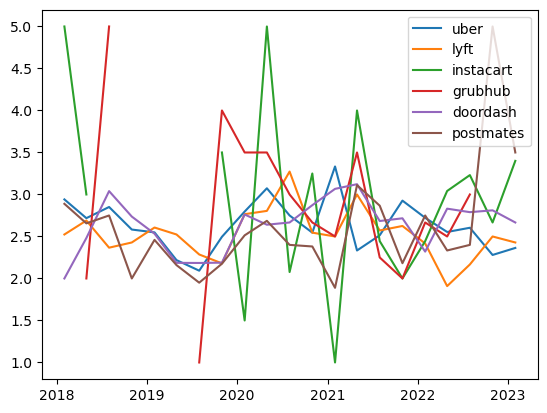

In [28]:
col = "compensation_and_benefits_rating"
companies = df["company"].unique().tolist()


for company in companies:
    company_data = df[df["company"] == company]
    company_data = company_data[company_data[col] != 0]
    grouped = company_data.groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
    plt.plot(grouped.index, grouped[col], label=company)

plt.legend(loc='best')

In [136]:
grouped

,rating,job_work_and_life_balance_rating,compensation_and_benefits_rating,job_security_and_advancement_rating,management_rating,job_culture_rating,year,month,is_driver
datetime,,,,,,,,,
2018-03-31,3.608696,4.130435,2.391304,2.913043,3.347826,3.695652,2018.0,1.869565,1.0
2018-06-30,3.068966,3.896552,2.413793,2.689655,2.551724,3.068966,2018.0,4.620690,1.0
2018-09-30,4.028571,4.542857,2.942857,2.628571,3.057143,3.542857,2018.0,8.028571,1.0
2018-12-31,3.431818,3.522727,2.522727,2.590909,2.886364,3.204545,2018.0,11.000000,1.0
2019-03-31,3.000000,3.500000,2.250000,2.454545,2.681818,2.863636,2019.0,2.136364,1.0
2019-06-30,2.854545,3.345455,1.927273,2.109091,2.272727,2.527273,2019.0,5.072727,1.0
2019-09-30,2.906977,3.069767,1.883721,2.011628,2.151163,2.465116,2019.0,8.104651,1.0
2019-12-31,3.410714,3.517857,2.339286,2.535714,2.857143,2.839286,2019.0,11.107143,1.0
2020-03-31,3.500000,3.838235,2.602941,2.735294,2.941176,3.102941,2020.0,1.867647,1.0


<Axes: xlabel='year,month'>

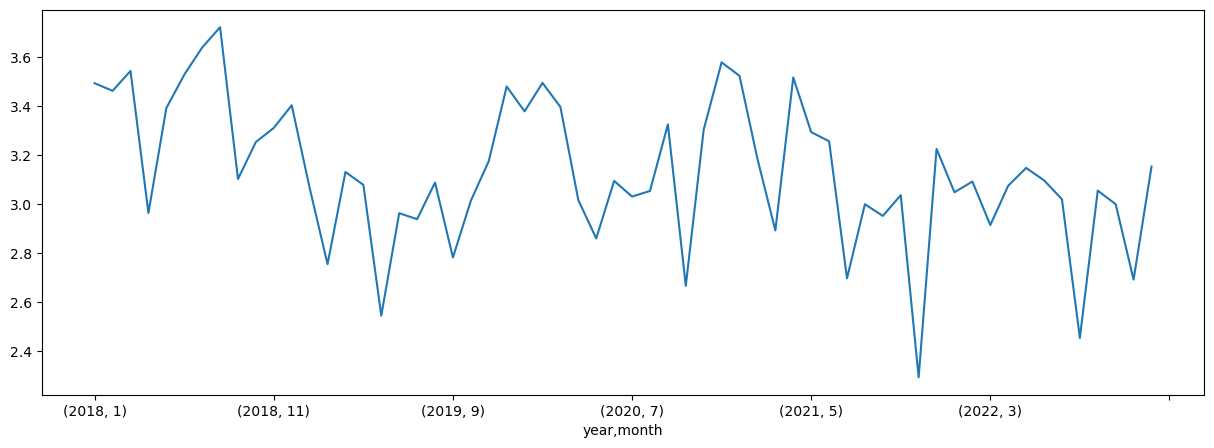

In [103]:
col = "job_culture_rating"
df[df[col] != 0].groupby(["year", "month"])[col].mean().plot( figsize=(15, 5))

/tmp/ipykernel_11903/1912766848.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby([ 'year', 'month'])['job_security_and_advancement_rating', "job_work_and_life_balance_rating",


<Axes: xlabel='year,month'>

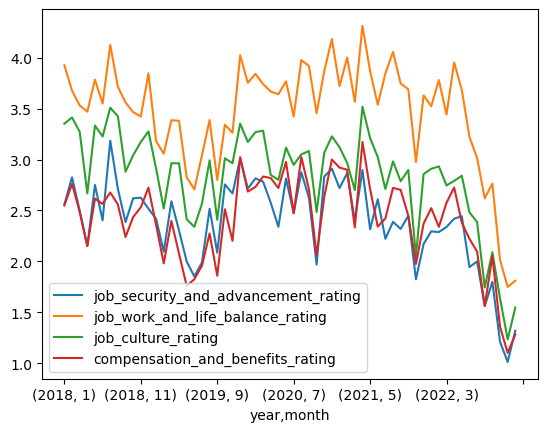

In [67]:
df.groupby([ 'year', 'month'])['job_security_and_advancement_rating', "job_work_and_life_balance_rating",
                               "job_culture_rating", "compensation_and_benefits_rating"].mean().plot()

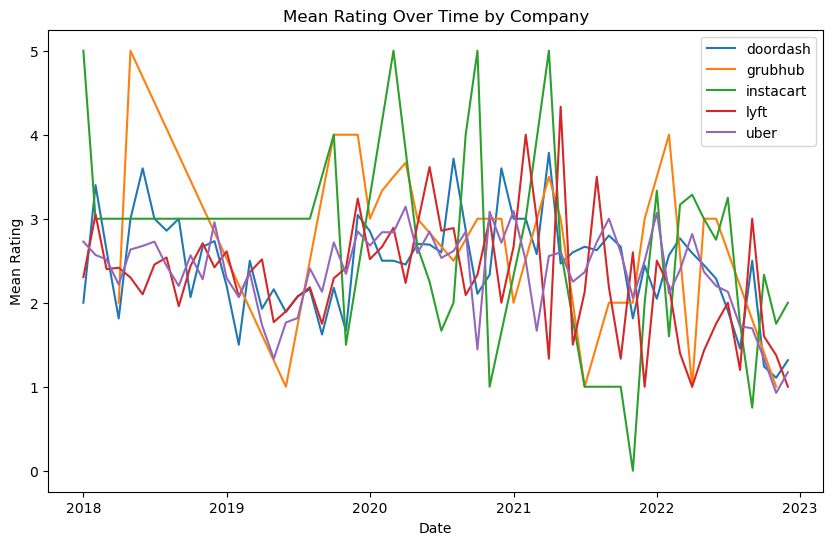

In [68]:
mean_rating = df.groupby(['company', 'year', 'month'])[col].mean().reset_index()

# generate a datetime for plotting
mean_rating['date'] = pd.to_datetime(mean_rating[['year', 'month']].assign(day=1))

# create a list of companies
companies = mean_rating['company'].unique()

# plot
plt.figure(figsize=(10,6))

for company in companies:
    company_data = mean_rating[mean_rating['company'] == company]
    plt.plot_date(company_data['date'], company_data[col], '-', label=company)

plt.title('Mean Rating Over Time by Company')
plt.xlabel('Date')
plt.ylabel('Mean Rating')
plt.legend()
plt.show()

In [ ]:
cols = ["rating", 'job_work_and_life_balance_rating', 'compensation_and_benefits_rating', 'job_security_and_advancement_rating', 'management_rating', 'job_culture_rating']
col = "compensation_and_benefits_rating"
company = "uber"
tdf = df_ca[(df_ca[col] > 0) & (df_ca["company"] == company)]
grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
plt.plot(grouped.index, grouped[col])
tdf = df_tx[(df_tx[col] > 0) & (df_tx["company"] == company)]
grouped = tdf[["datetime", col]].groupby(pd.Grouper(key='datetime', freq='3M')).mean()  # 'Q' stands for quarter
plt.plot(grouped.index, grouped[col], color="red")